In [1]:
import gym
import torch
import torch.nn as nn
import numpy as np
import random
import matplotlib.pyplot as plt
from copy import deepcopy
from torch.distributions import MultivariateNormal
from datetime import datetime

In [2]:
class MeanSTDLinear(nn.Module):
    def __init__(self, input_dim, output_dim, mean_activation = None, std_activation = None):
        super().__init__()
        
        self.mean = nn.Linear(input_dim,output_dim)
        self.std = nn.Linear(input_dim,output_dim)
        self.mean_activation = mean_activation
        self.std_activation = std_activation
        
    def forward(self,x):
        mean = self.mean(x)
        std = self.std(x)
        if self.mean_activation:
            mean = self.mean_activation(mean)
        if self.std_activation:
            std = self.std_activation(std)
            
        return mean,std
    
class TanhRemap(nn.Module):
    def __init__(self, a = 0, b = 1):
        super().__init__()
        self.a = a
        self.b = b
        self.tanh = nn.Tanh()
        
    def forward(self,x):
        x = self.tanh(x)
        return ((x+1)/2)*(self.b-self.a)+self.a
        
        
        
class SAC(nn.Module):
    def __init__(self, state_dim, action_dim, gamma=0.99, alpha=1e-1, tau=1e-2, 
                 batch_size=64, pi_lr=1e-3, q_lr=1e-3):
        super().__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.pi_model = nn.Sequential(nn.Linear(state_dim, 128), nn.ReLU(), 
                                      nn.Linear(128, 128), nn.ReLU(),  
                                      MeanSTDLinear(128, action_dim,
                                          nn.Tanh(),
                                          TanhRemap(-3,0))).to(self.device)

        self.q1_model = nn.Sequential(nn.Linear(state_dim + action_dim, 128), nn.ReLU(), 
                                      nn.Linear(128, 128), nn.ReLU(), 
                                      nn.Linear(128, 1)).to(self.device)

        self.q2_model = nn.Sequential(nn.Linear(state_dim + action_dim, 128), nn.ReLU(), 
                                      nn.Linear(128, 128), nn.ReLU(), 
                                      nn.Linear(128, 1)).to(self.device)

        self.gamma = gamma
        self.alpha = alpha
        self.tau = tau
        self.batch_size = batch_size
        self.memory = []
        self.memory_lim = 40000

        self.pi_optimizer = torch.optim.Adam(self.pi_model.parameters(), pi_lr)
        self.q1_optimizer = torch.optim.Adam(self.q1_model.parameters(), q_lr)
        self.q2_optimizer = torch.optim.Adam(self.q2_model.parameters(), q_lr)
        self.q1_target_model = deepcopy(self.q1_model)
        self.q2_target_model = deepcopy(self.q2_model)

    def get_action(self, state):
        state = torch.FloatTensor(state).to(self.device)
        action, log_prob, log_stds = self.predict_actions(state)
        return action.cpu().detach().numpy(), torch.exp(log_stds).cpu().detach().numpy()

    def fit(self, state, action, reward, done, next_state, do_update_pi = True):
        self.memory.append([state, action, reward, done, next_state])

        if len(self.memory) > self.batch_size:
            if len(self.memory) > self.memory_lim:
                self.memory = self.memory[-self.memory_lim:]
            batch = random.sample(self.memory, self.batch_size)
            states, actions, rewards, dones, next_states = map(torch.FloatTensor, zip(*batch))
            states, actions, rewards, dones, next_states = states.to(self.device), actions.to(self.device), rewards.to(self.device), dones.to(self.device), next_states.to(self.device)

            rewards, dones = rewards.unsqueeze(1), dones.unsqueeze(1)
            
            next_actions, next_log_probs, _ = self.predict_actions(next_states)
            next_log_probs = next_log_probs.unsqueeze(1)
            next_states_and_actions = torch.concat((next_states, next_actions), dim=1)
            next_q1_values = self.q1_target_model(next_states_and_actions)
            next_q2_values = self.q2_target_model(next_states_and_actions)
            next_min_q_values = torch.min(next_q1_values, next_q2_values)
            targets = rewards + self.gamma * (1 - dones) * (next_min_q_values - self.alpha * next_log_probs)
            states_and_actions = torch.concat((states, actions), dim=1)
            q1_loss = torch.mean((self.q1_model(states_and_actions) - targets.detach()) ** 2)
            q2_loss = torch.mean((self.q2_model(states_and_actions) - targets.detach()) ** 2)
            self.update_model(q1_loss, self.q1_optimizer, self.q1_model, self.q1_target_model)
            self.update_model(q2_loss, self.q2_optimizer, self.q2_model, self.q2_target_model)
            
            if do_update_pi:
                pred_actions, log_probs, _ = self.predict_actions(states)
                log_probs = log_probs.unsqueeze(1)
                states_and_pred_actions = torch.concat((states, pred_actions), dim=1)
                q1_values = self.q1_model(states_and_pred_actions)
                q2_values = self.q2_model(states_and_pred_actions)
                min_q_values = torch.min(q1_values, q2_values)
                pi_loss = - torch.mean(min_q_values - self.alpha * log_probs)
                self.update_model(pi_loss, self.pi_optimizer)
            
    def update_model(self, loss, optimizer, model=None, target_model=None):
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if model != None and target_model != None:
            for param, terget_param in zip(model.parameters(), target_model.parameters()):
                new_terget_param = (1 - self.tau) * terget_param + self.tau * param
                terget_param.data.copy_(new_terget_param)

    def predict_actions(self, states):
        means, log_stds = self.pi_model(states)
        dists = MultivariateNormal(means, torch.diag_embed(torch.exp(log_stds)))
        actions = dists.rsample()
        log_probs = dists.log_prob(actions)
        return actions, log_probs, log_stds

In [3]:
env = gym.make("LunarLander-v2", continuous = True)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

agent = SAC(state_dim, action_dim)

total_rewards = []
propbs = []

In [4]:
%%time

episode_n = 600

for episode in range(episode_n):

    total_reward = 0
    mean_prob = 0
    state = env.reset()
    
    for t in range(1000):
        action, stds = agent.get_action(state)
        mean_prob += np.mean(stds)
        next_state, reward, done, _ = env.step(action)
    
        agent.fit(state, action, reward, done, next_state, do_update_pi=t%2)
    
        total_reward += reward
        state = next_state
        if done:
            mean_prob /= t+1
            break

    total_rewards.append(total_reward)
    propbs.append(mean_prob)
    
    print(episode,total_reward,mean_prob,len(agent.memory),'   ',end='\r')

C:\Users\boh-b\AppData\Local\Temp\ipykernel_15164\3519913960.py:77: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:204.)
  states, actions, rewards, dones, next_states = map(torch.FloatTensor, zip(*batch))


CPU times: total: 19min 2s022890669107437 40000      
Wall time: 3h 47min 4s


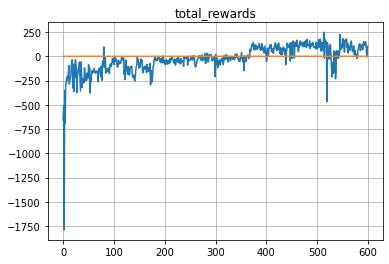

In [5]:
plt.plot(total_rewards)
plt.plot(np.array(propbs))
plt.title('total_rewards')
plt.grid()
plt.show()

In [6]:
total_reward = 0
state = env.reset()
for t in range(500):
    action, std = agent.get_action(state)
    env.render()
    state, reward, done, _ = env.step(action)
    total_reward += reward
    
    if done:
        break
        
print(total_reward)

138.4343242575606


In [7]:
def predict_actions_det(agent, states):
    means, log_stds = agent.pi_model(states)
    dists = MultivariateNormal(means, 0.0005*torch.diag_embed(torch.exp(log_stds)))
    actions = dists.rsample()
    log_probs = dists.log_prob(actions)
    return actions, log_probs, log_stds

def get_action_det(agent, state):
    state = torch.FloatTensor(state).to(agent.device)
    action, log_prob, log_stds = predict_actions_det(agent,state)
    return action.cpu().detach().numpy(), torch.exp(log_stds).cpu().detach().numpy()

total_reward = 0
state = env.reset()
for t in range(500):
    action,_ = get_action_det(agent,state)
    env.render()
    state, reward, done, _ = env.step(action)
    total_reward += reward
    
    if done:
        break
        
print(total_reward)

23.54062466088144


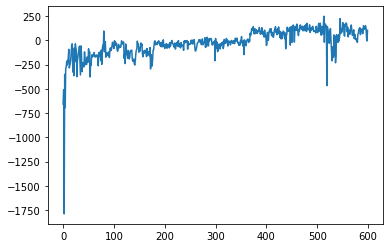

In [8]:
hist = np.array([[i for i in range(len(total_rewards))],total_rewards]).T
plt.plot(hist[:,1])

In [9]:
np.savetxt('sac0.txt',hist)

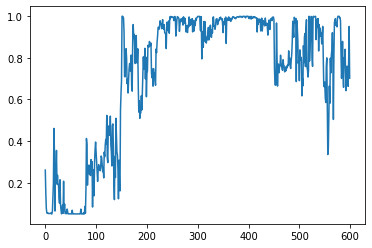

In [10]:
hist1 = np.array([[i for i in range(len(propbs))],propbs]).T
plt.plot(hist1[:,1])

In [11]:
np.savetxt('sac0_prob.txt',hist1)